### Importing The Dataset

In [180]:
# Identify the encoding of files
import chardet

encoding_train = ""
encoding_test = ""

with open("./TrainingData.csv", "rb") as f:
    result = chardet.detect(f.read())
    encoding_train = result.get('encoding', 'UTF-8')

with open("./TestData.csv", "rb") as f:
    result = chardet.detect(f.read())
    encoding_test = result.get('encoding', 'UTF-8')

In [181]:
# Import the datasets
import pandas as pd

df_train = pd.read_csv('./TrainingData.csv', encoding=encoding_train)
df_test = pd.read_csv('./TestData.csv', encoding=encoding_test)

### Previewing the Dataset

In [182]:
df_train.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [183]:
df_train["label"].value_counts()

label
ham     3381
spam     519
Name: count, dtype: int64

In [184]:
df_test.head()

,message
0,That depends. How would you like to be treated...
1,"Right on brah, see you later"
2,Waiting in e car 4 my mum lor. U leh? Reach ho...
3,Your 2004 account for 07XXXXXXXXX shows 786 un...
4,Do you want a new video handset? 750 anytime a...


### Preprocessing

In [185]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Preprocessing function for 'message'
def message_to_token_list(s):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(s) # convert string message to a list of tokens (an array of string words)
    
    lowercased_tokens = [t.lower() for t in tokens]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens] # group word variations to a standard word for tallying

    sw = stopwords.words('english')
    useful_tokens = [t for t in lemmatized_tokens if t not in sw] # remove stopwords / filler words / common words

    return useful_tokens

In [186]:
# let ham = 0, spam = 1
df_train['label'] = df_train['label'].map({'ham': 0, 'spam': 1})

In [187]:
# randomize all records
df_train = df_train.sample(frac=1, random_state=1) 
df_train = df_train.reset_index(drop=True)

# split to training set and testing set
split_index = int(len(df_train) * 0.8) 
train_df, test_df = df_train[:split_index], df_train[split_index:]

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df, test_df

(      label                                            message
 0         0  Height of Confidence: All the Aeronautics prof...
 1         1  Someone has conacted our dating service and en...
 2         0  I was at bugis juz now wat... But now i'm walk...
 3         0             We have all rounder:)so not required:)
 4         0  Sweet, we may or may not go to 4U to meet carl...
 ...     ...                                                ...
 3115      0    What time should I tell my friend to be around?
 3116      0                 U guys never invite me anywhere :(
 3117      0          Trust me. Even if isn't there, its there.
 3118      1  Double your mins & txts on Orange or 1/2 price...
 3119      1  GENT! We are trying to contact you. Last weeke...
 
 [3120 rows x 2 columns],
      label                                            message
 0        0  Too late. I said i have the website. I didn't ...
 1        0  In fact when do you leave? I think addie goes ...
 2        0    

In [188]:
# Tally detected tokens
token_counter = {}

for message in train_df['message']:
  message_as_token_lst = message_to_token_list(message)

  for token in message_as_token_lst:
    if token in token_counter:
      token_counter[token] += 1
    else:
      token_counter[token] = 1

len(token_counter)

5916

In [189]:
token_counter

{'height': 4,
 'confidence': 4,
 'aeronautics': 2,
 'professor': 2,
 'wer': 6,
 'calld': 2,
 'amp': 48,
 'askd': 9,
 '2': 285,
 'sit': 5,
 'aeroplane': 2,
 'aftr': 5,
 'sat': 16,
 'told': 24,
 'dat': 22,
 'plane': 5,
 'w': 11,
 'made': 18,
 'student': 6,
 'dey': 4,
 'hurried': 2,
 'bt': 18,
 '1': 103,
 'didnt': 14,
 'move': 9,
 'said': 57,
 'someone': 34,
 'ha': 75,
 'conacted': 1,
 'dating': 11,
 'service': 47,
 'entered': 9,
 'phone': 73,
 'fancy': 12,
 'find': 46,
 'call': 330,
 'landline': 18,
 '09111030116': 1,
 'pobox12n146tf15': 1,
 'wa': 117,
 'bugis': 5,
 'juz': 12,
 'wat': 58,
 'walking': 4,
 'home': 84,
 'oredi': 11,
 'ìï': 27,
 'late': 40,
 'reply': 79,
 'oso': 12,
 'saw': 13,
 'top': 16,
 'like': 136,
 'din': 4,
 'buy': 33,
 'r': 101,
 'ì_': 69,
 'rounder': 1,
 'required': 1,
 'sweet': 21,
 'may': 29,
 'go': 167,
 '4u': 6,
 'meet': 54,
 'carlos': 12,
 'gauge': 1,
 'patty': 2,
 'interest': 2,
 'boo': 3,
 'way': 60,
 'mom': 14,
 'making': 13,
 'tortilla': 2,
 'soup': 1,
 'yu

In [190]:
# says if a token exists at least a *threshold number of times
def keep_token(proccessed_token, threshold):
  if proccessed_token not in token_counter:
    return False
  else:
    return token_counter[proccessed_token] > threshold

In [191]:
#Selects features based on tokens that occur at least 20 times
features = set()

for token in token_counter:
  if keep_token(token, 20):
    features.add(token)

features

{'1',
 '10',
 '100',
 '1000',
 '150p',
 '16',
 '18',
 '2',
 '3',
 '4',
 '5',
 '50',
 '500',
 '6',
 '7',
 '8',
 'account',
 'already',
 'also',
 'always',
 'amp',
 'anything',
 'around',
 'ask',
 'b',
 'babe',
 'back',
 'best',
 'better',
 'bit',
 'buy',
 'c',
 'call',
 'cant',
 'car',
 'care',
 'cash',
 'chance',
 'chat',
 'check',
 'claim',
 'class',
 'co',
 'com',
 'come',
 'coming',
 'contact',
 'cool',
 'cost',
 'could',
 'customer',
 'da',
 'dat',
 'day',
 'dear',
 'done',
 'dont',
 'draw',
 'dun',
 'dunno',
 'e',
 'eat',
 'end',
 'even',
 'ever',
 'every',
 'feel',
 'find',
 'fine',
 'finish',
 'first',
 'free',
 'friend',
 'get',
 'getting',
 'girl',
 'give',
 'go',
 'god',
 'going',
 'gonna',
 'good',
 'got',
 'great',
 'gt',
 'guaranteed',
 'gud',
 'guess',
 'guy',
 'ha',
 'haha',
 'happy',
 'heart',
 'hello',
 'help',
 'hey',
 'hi',
 'home',
 'hope',
 'hour',
 'house',
 'ill',
 'im',
 'job',
 'jus',
 'k',
 'keep',
 'know',
 'lar',
 'last',
 'late',
 'later',
 'leave',
 'let',

In [192]:
features = list(features)
token_to_index_mapping = {t:i for t, i in zip(features, range(len(features)))}
token_to_index_mapping 

{'class': 0,
 'tv': 1,
 '2': 2,
 'receive': 3,
 'da': 4,
 'cash': 5,
 'try': 6,
 'phone': 7,
 'need': 8,
 'dun': 9,
 '7': 10,
 'happy': 11,
 'draw': 12,
 'room': 13,
 'sorry': 14,
 'gt': 15,
 'call': 16,
 'message': 17,
 'love': 18,
 'ready': 19,
 'å': 20,
 'think': 21,
 'sm': 22,
 'hello': 23,
 '8': 24,
 'come': 25,
 'stuff': 26,
 'see': 27,
 'babe': 28,
 'sir': 29,
 'go': 30,
 '1': 31,
 'voucher': 32,
 'chance': 33,
 'reply': 34,
 'customer': 35,
 'mobile': 36,
 'fine': 37,
 'plan': 38,
 '16': 39,
 'something': 40,
 'guaranteed': 41,
 'told': 42,
 'around': 43,
 'xxx': 44,
 'ill': 45,
 'home': 46,
 'yet': 47,
 'went': 48,
 'lt': 49,
 'r': 50,
 'name': 51,
 'next': 52,
 'thk': 53,
 'weekend': 54,
 'b': 55,
 'done': 56,
 'eat': 57,
 'tomorrow': 58,
 'princess': 59,
 'wa': 60,
 'sweet': 61,
 'many': 62,
 'lar': 63,
 'thanks': 64,
 'cost': 65,
 'ìï': 66,
 'contact': 67,
 'www': 68,
 'long': 69,
 'know': 70,
 'lor': 71,
 'get': 72,
 'ask': 73,
 'tone': 74,
 'v': 75,
 'meeting': 76,
 'keep

In [193]:
import numpy as np

# converts a message to a vector tallying the existence of a feature in *message
def message_to_count_vector(message):
  count_vector = np.zeros(len(features))

  processed_list_of_tokens = message_to_token_list(message)

  for token in processed_list_of_tokens:
    if token not in features:
      continue
    index = token_to_index_mapping[token]
    count_vector[index] += 1
  
  return count_vector

In [194]:
def messages_to_count_vectors(messages):
    count_vectors = []

    for message in messages:
        count_vector = message_to_count_vector(message)
        count_vectors.append(count_vector)

    return count_vectors

In [195]:
# Converts data (message = spam | ham) to (feature vector = 1 | 0 )
def df_to_X_y(dff):
  y = dff['label'].to_numpy().astype(int)

  message_col = dff['message']
    
  count_vectors = messages_to_count_vectors(message_col)

  # for message in message_col:
  #   count_vector = message_to_count_vector(message)
  #   count_vectors.append(count_vector)

  X = np.array(count_vectors).astype(int)

  return X, y

In [196]:
train_df

,label,message
0,0,Height of Confidence: All the Aeronautics prof...
1,1,Someone has conacted our dating service and en...
2,0,I was at bugis juz now wat... But now i'm walk...
3,0,We have all rounder:)so not required:)
4,0,"Sweet, we may or may not go to 4U to meet carl..."
...,...,...
3115,0,What time should I tell my friend to be around?
3116,0,U guys never invite me anywhere :(
3117,0,"Trust me. Even if isn't there, its there."
3118,1,Double your mins & txts on Orange or 1/2 price...


In [197]:
train_df['label'] = train_df['label'] # .map({'ham': 0, 'spam': 1})
X_train, y_train = df_to_X_y(train_df)

test_df['label'] = test_df['label'] # .map({'ham': 0, 'spam': 1})
X_test, y_test = df_to_X_y(test_df)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3120, 265), (3120,), (780, 265), (780,))

In [198]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train)

X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

X_train

array([[0.  , 0.  , 0.25, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [199]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression().fit(X_train, y_train)

In [200]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       677
           1       0.97      0.84      0.90       103

    accuracy                           0.98       780
   macro avg       0.97      0.92      0.94       780
weighted avg       0.98      0.98      0.97       780



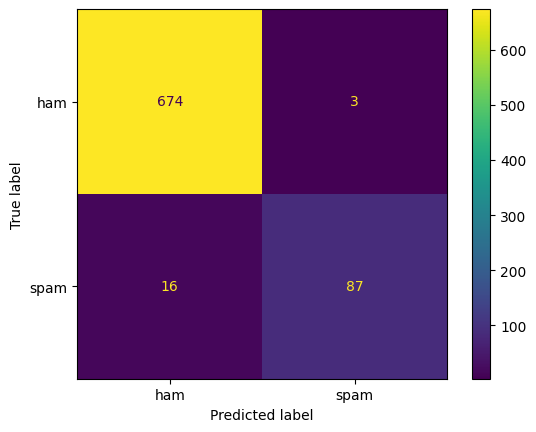

In [201]:
# Display Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_predictions = lr.predict(X_test)
cm = confusion_matrix(y_test, test_predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['ham', 'spam'])
disp.plot()

In [215]:
output = pd.DataFrame({"message":df_test['message'], 'label':lr.predict(messages_to_count_vectors(df_test['message']))})

output['label'] = output['label'].map({0: "ham", 1: "spam"})

In [219]:
output.to_csv("Pajarillo.csv", index=False, quoting=csv.QUOTE_ALL)

NameError: name 'csv' is not defined